In [10]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# generate class activation mapping


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# initialize model, switch to eval model, load trained weights
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)
model.load_state_dict(torch.load('model.pth'))
model = model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

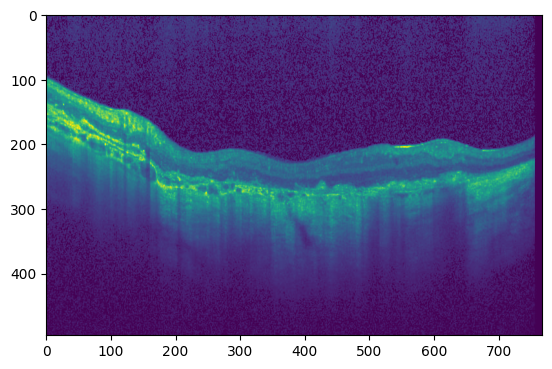

In [13]:
#display image
from matplotlib.pyplot import imshow
from PIL import Image
image = Image.open('data/test/CNV/cnv_test_1007.jpg')
imshow(image)

In [14]:
if image.mode != "RGB":
    # Convert the image to RGB mode if it is not already
    image = image.convert("RGB")

In [15]:
# define transforms
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
display_transform = transforms.Compose([
    transforms.Resize((224,224)),
])

In [16]:
# preprocess image
tensor = preprocess(image)

In [17]:
# add batch dimension
from torch.autograd import Variable
predicted_var = Variable(tensor.unsqueeze(0).to(device), requires_grad=True)

In [18]:
# class activation mapping
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [19]:
# get the activations of the last convolutional layer
final_layer = model._modules.get('layer4')

In [20]:
activated_features = SaveFeatures(final_layer)

In [21]:
# get the prediction
from torch.nn import functional as F
prediction = model(predicted_var)
pred_probabilites = F.softmax(prediction).data.squeeze()
activated_features.remove()
prediction

C:\Users\HASSEN\AppData\Local\Temp\ipykernel_4160\3310598900.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilites = F.softmax(prediction).data.squeeze()


tensor([[-1.3232,  8.8573, -3.2721,  1.0277, -1.1273,  1.6092, -5.6888,  0.5973]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:

from torch import topk
topk(pred_probabilites, 1)

torch.return_types.topk(
values=tensor([0.9985], device='cuda:0'),
indices=tensor([1], device='cuda:0'))

In [23]:
#function to generate class activation mapping
import cv2
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

In [24]:
# get the weight of the last fc layer
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [25]:
# generate class activation mapping for the top1 prediction
weight_softmax_params

[Parameter containing:
 tensor([[-0.0010, -0.0203, -0.1017,  ...,  0.0448, -0.0045, -0.0507],
         [ 0.0434, -0.0561, -0.0020,  ...,  0.0763,  0.0557,  0.0420],
         [-0.0593,  0.0771,  0.0777,  ..., -0.0297, -0.1155,  0.0571],
         ...,
         [ 0.0543, -0.0883, -0.0097,  ..., -0.0533,  0.0459,  0.0322],
         [-0.0306,  0.0842,  0.0894,  ...,  0.0140, -0.0943, -0.1263],
         [-0.0352, -0.0410, -0.0067,  ..., -0.0131,  0.0795,  0.0352]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0676, -0.0250, -0.0081, -0.0080,  0.0036,  0.0021,  0.0221, -0.0004],
        device='cuda:0', requires_grad=True)]

In [26]:
class_idx = topk(pred_probabilites, 1)[1].int()

In [27]:
# generate class activation mapping
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

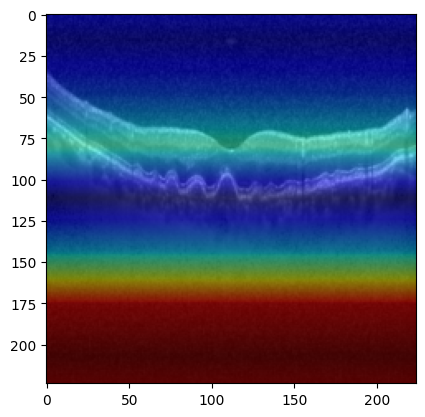

In [29]:
import skimage.transform
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

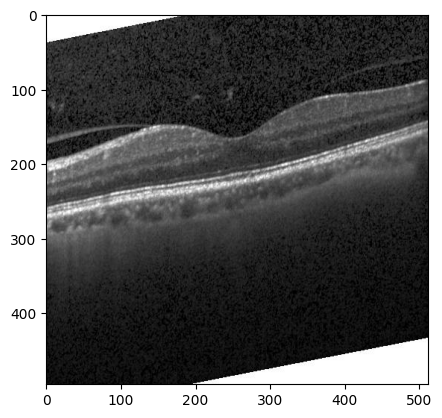

NORMAL
predicted class:  NORMAL


C:\Users\HASSEN\AppData\Local\Temp\ipykernel_4160\1749178197.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilites = F.softmax(prediction).data.squeeze()


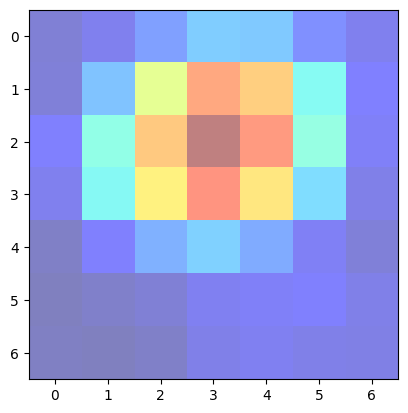

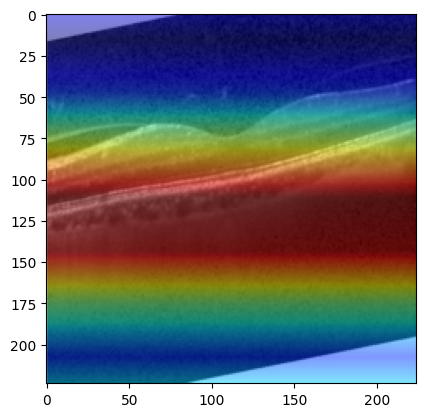

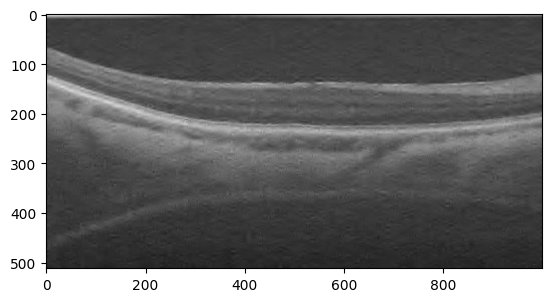

AMD
predicted class:  AMD


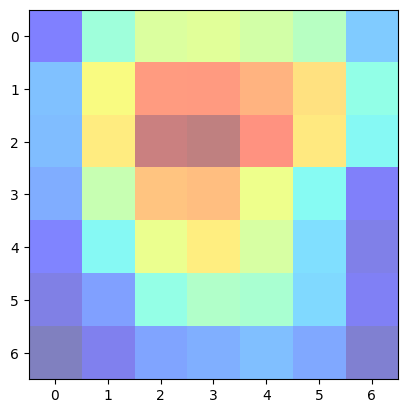

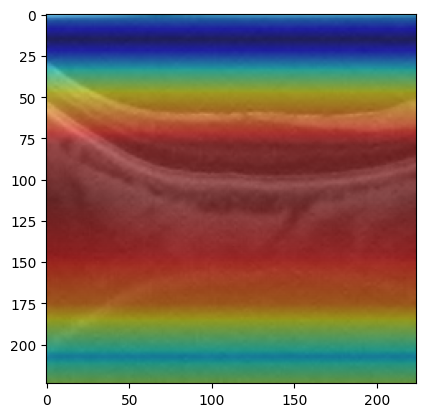

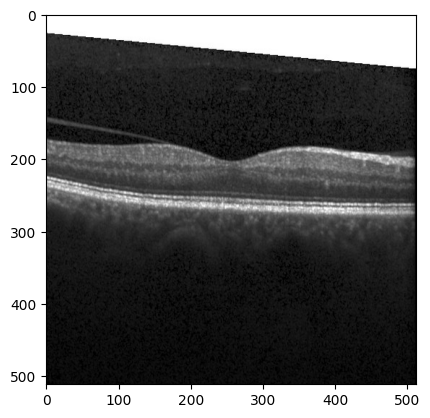

NORMAL
predicted class:  NORMAL


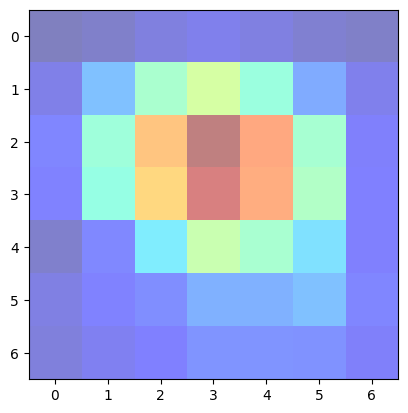

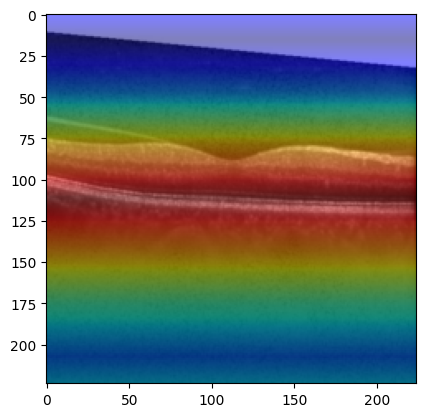

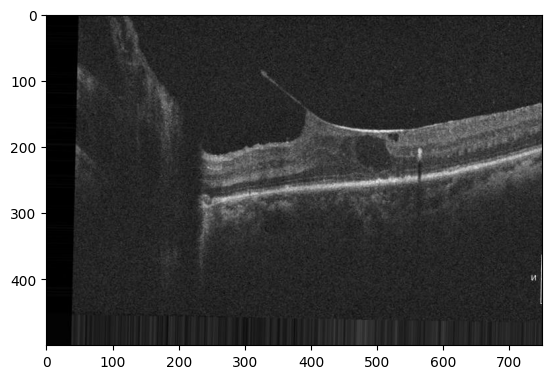

DR
predicted class:  DR


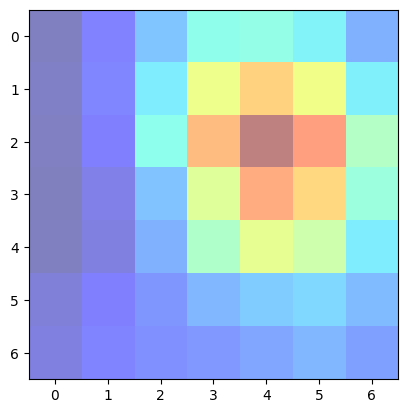

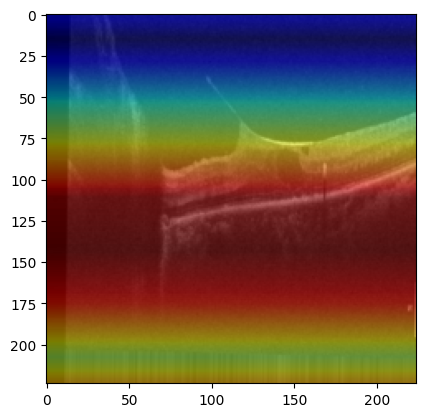

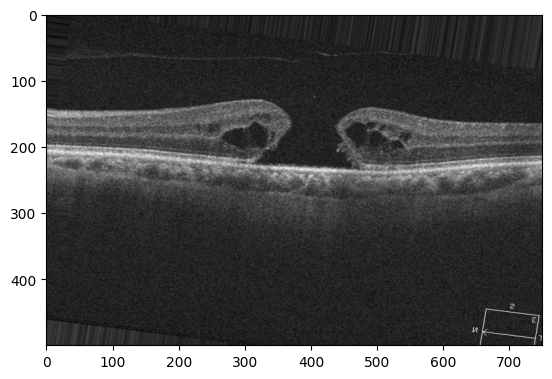

MH
predicted class:  MH


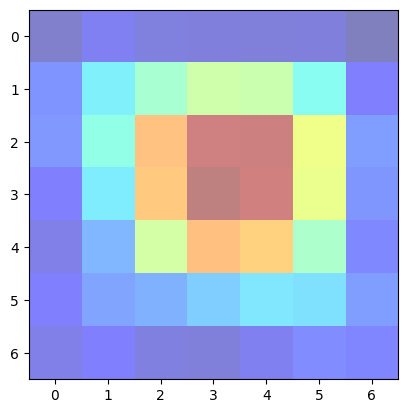

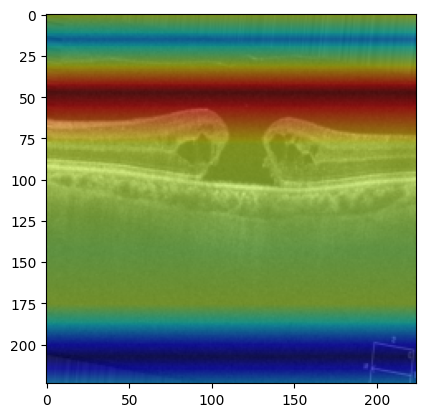

In [48]:
#dispaly 5 random images from the test set and their labels
import random
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import skimage.transform

mask = []
image_lst = []
grad = []
path = 'data/test'
classes = os.listdir(path)
for i in range(5):
    class_name = random.choice(classes)
    class_path = os.path.join(path, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    image = Image.open(image_path)
    image_lst.append(image_path)
    if image.mode != "RGB":
        # Convert the image to RGB mode if it is not already
        image = image.convert("RGB")
    imshow(image)
    plt.show()
    print(class_name)
    #print the class activation mapping for the image
    tensor = preprocess(image)
    predicted_var = Variable(tensor.unsqueeze(0).to(device), requires_grad=True)
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    prediction = model(predicted_var)
    pred_probabilites = F.softmax(prediction).data.squeeze()
    activated_features.remove()
    class_idx = topk(pred_probabilites, 1)[1].int()
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    overlay = getCAM(activated_features.features, weight_softmax, class_idx)
    print('predicted class: ', classes[class_idx])
    plt.imshow(overlay, alpha=0.5, cmap='jet')
    plt.show()
    imshow(display_transform(image))
    imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
    plt.show()
    #create a mask for the image wich is a value between 0 and 1
    mask.append(overlay[0])
    #insert the value of calculated gradient into the grad list
    grad.append(overlay[0].mean())